# 0.0. Imports

## 0.1. Bibliotecas

In [2]:
import re
import numpy   as np
import pandas  as pd
import seaborn as sns

import umap.umap_ as umap

from IPython.display import HTML
from matplotlib import pyplot as plt


from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import ensemble      as en
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold      as mn
from sklearn import mixture       as mx

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.2. Helper Functions

## 0.3. Load dataset

In [3]:
# load data
df_raw = pd.read_csv('/content/Ecommerce.csv', encoding='windows-1252')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

# <font color='red'> 1.0. Descrição dos dados </font>

In [4]:
df1 = df_raw.copy()

## 1.1. Rename columuns

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [6]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [10]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [11]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributs

In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.2. Categorical Attributs

#### Invoice No

In [15]:
# identficacao:
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock Code

In [16]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [17]:
df1.head()

# Acão: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### Country

In [18]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [19]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [20]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color='red'> 2.0. Filtragem de Variáveis </font>

In [21]:
df2 = df1.copy()

In [22]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [23]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# <font color='red'> 3.0. Feature Engineering </font>

In [24]:
df3 = df2.copy()

## 3.1. Feature Creation

In [25]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [26]:
df_ref.shape

(5786, 1)

### 3.1.1. Gross Revenue

In [27]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

<ipython-input-27-fff7144dd8ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [28]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Quantity of products purchased

In [29]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
dtype: int64

### 3.1.4. Frequency Purchase

In [30]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ),
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
dtype: int64

### 3.1.5. Number of Returns

In [31]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [32]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_products    0
frequency        0
qtde_returns     0
dtype: int64

In [33]:
len( df4['customer_id'].unique() )

5695

## 4.1. Univariate Analysis

## 4.2. Bivariate Analysis

In [34]:
cols = ['customer_id']
df42 = df4.drop( cols, axis=1 )

<Figure size 2500x1200 with 0 Axes>

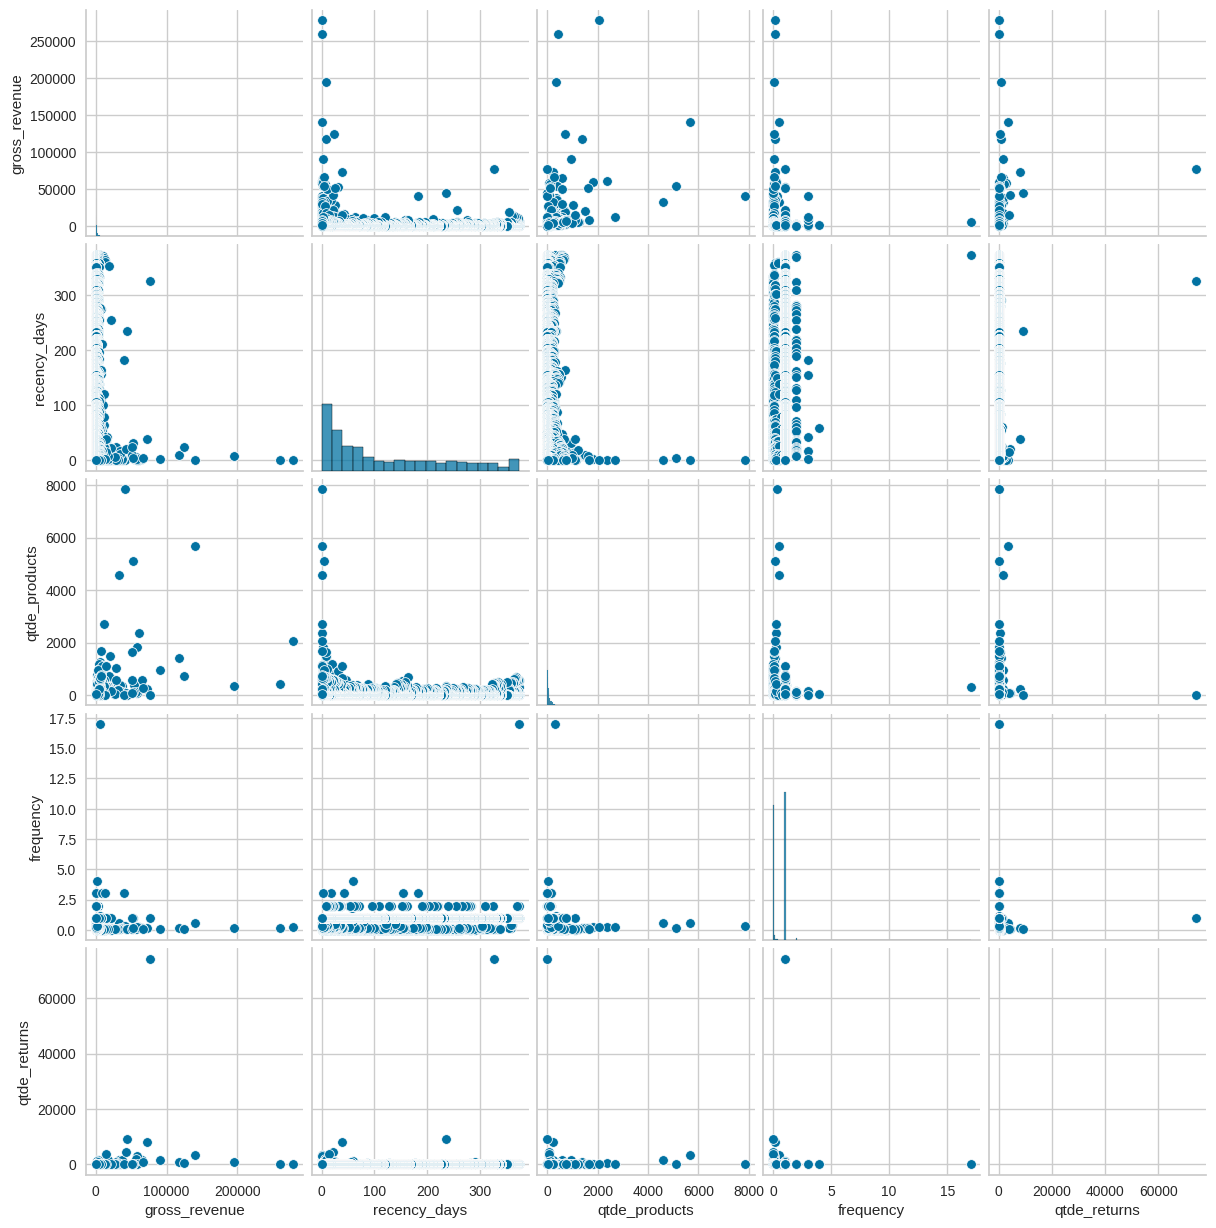

In [35]:
plt.figure( figsize=(25, 12) )
sns.pairplot( df42 )

## 4.3. Estudo do Espaço

In [36]:
# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[ cols_selected ].copy()

In [37]:
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']           = mm.fit_transform( df43[['recency_days']] )
df43['qtde_products']          = mm.fit_transform( df43[['qtde_products']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])


X = df43.copy()

In [38]:
X.shape

(5695, 6)

### 4.3.1. PCA

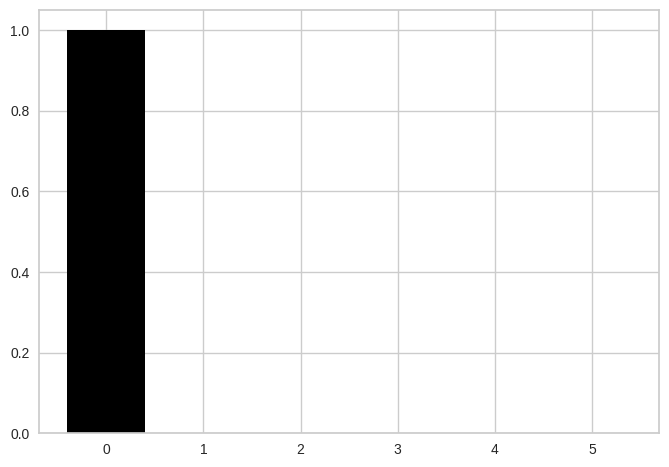

In [39]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<Axes: xlabel='0', ylabel='1'>

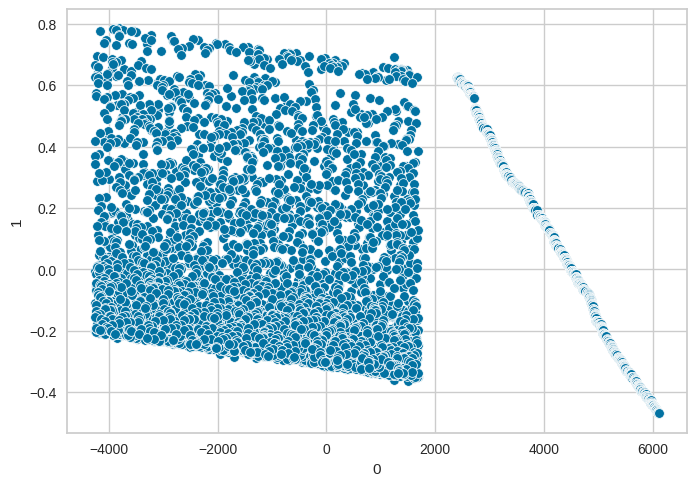

In [40]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2. UMAP

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

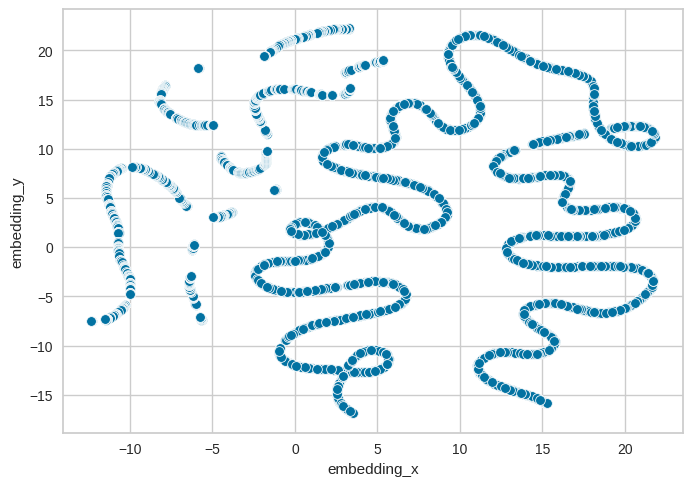

In [41]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data=df_pca )

### 4.3.3. t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

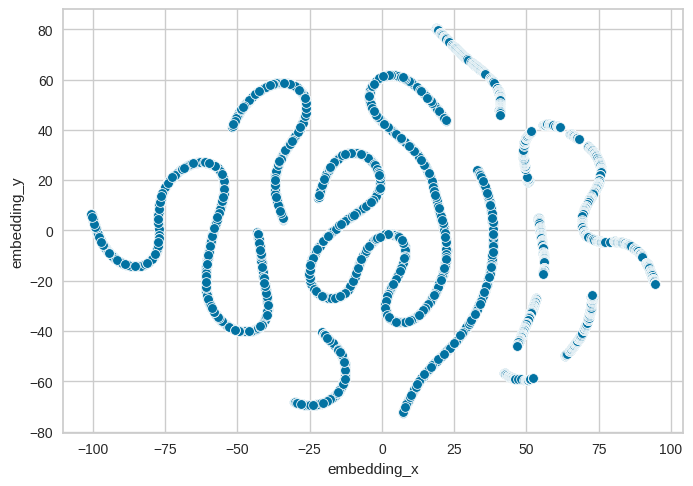

In [42]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data=df_pca )

### 4.3.4. Tree-Based Embedding

In [43]:
# training dataset
X = df43.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

RandomForestRegressor(random_state=42)

In [44]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

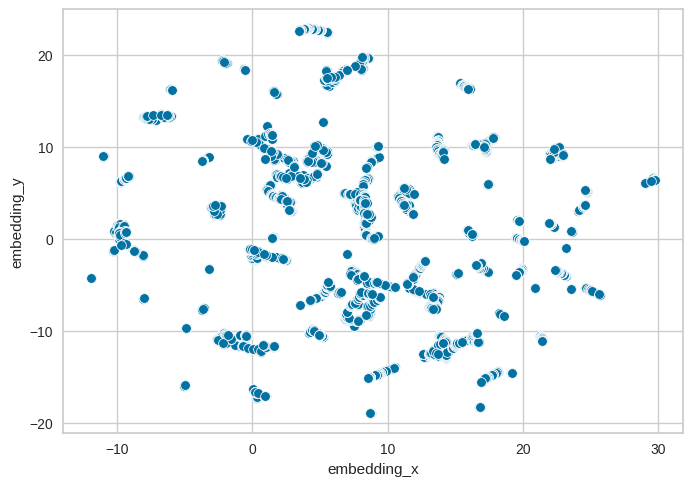

In [45]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data=df_tree )

# <font color='red'> 5.0. Data Preparation </font>

In [46]:
df5 = df_tree.copy()

# <font color='red'> 6.0. Feature Selection </font>

In [47]:
df6 = df_tree.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [48]:
X = df_tree.copy()

In [49]:
X.head()

,embedding_x,embedding_y
0,1.315101,9.531459
1,5.054254,9.672614
2,1.786388,9.235450
3,-6.708790,13.231411
4,-5.041775,-15.944134


In [50]:
clusters = np.arange( 2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

## 7.1. K-Means

In [51]:
from sklearn import metrics as m

In [52]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

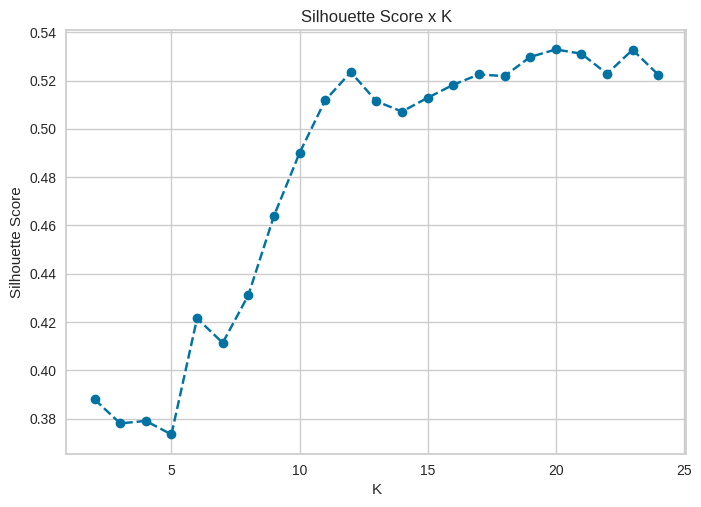

In [53]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2. GMM

In [54]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

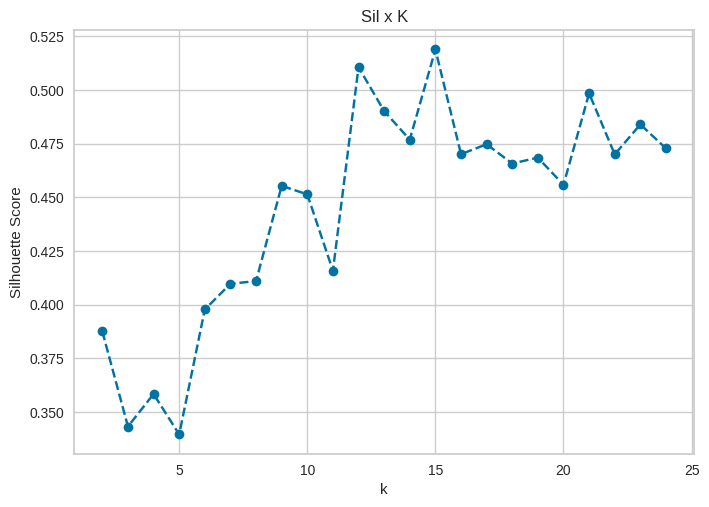

In [55]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3. Hierarchical Clustering

In [56]:
from scipy.cluster import hierarchy as hc

In [57]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

### 7.3.1. HClustering Silhouette Score

In [58]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

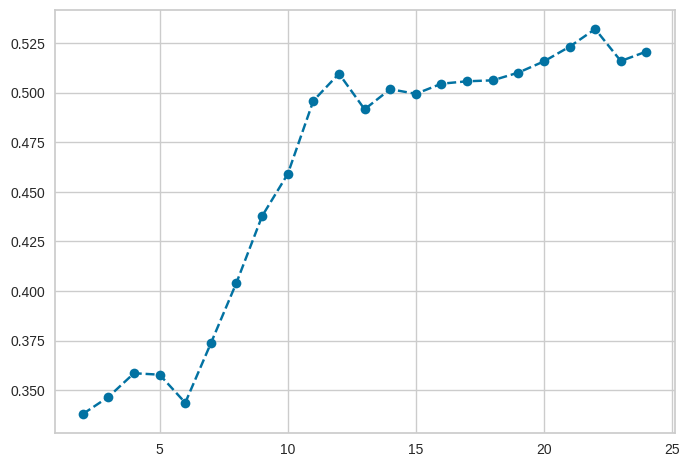

In [59]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4. DBSCAN

In [60]:
eps=2.00
min_samples=20

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( np.unique( labels ) ) ) )
print( np.unique( labels ) )

Silhouette Score: 0.5222032070159912
Number of Clusters: 40
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


In [61]:
from sklearn.neighbors import NearestNeighbors

In [62]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

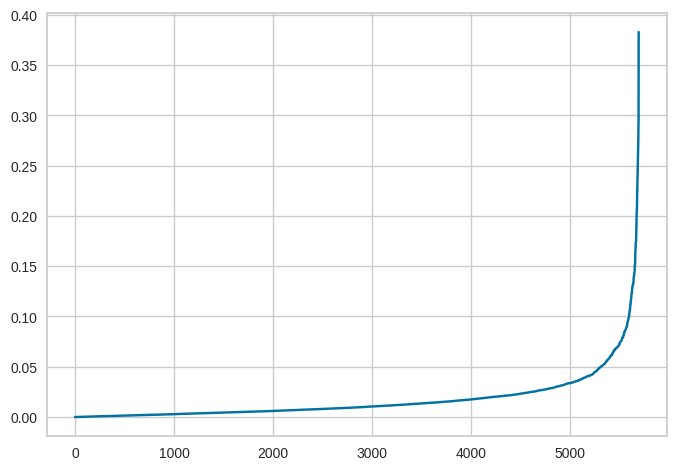

In [63]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

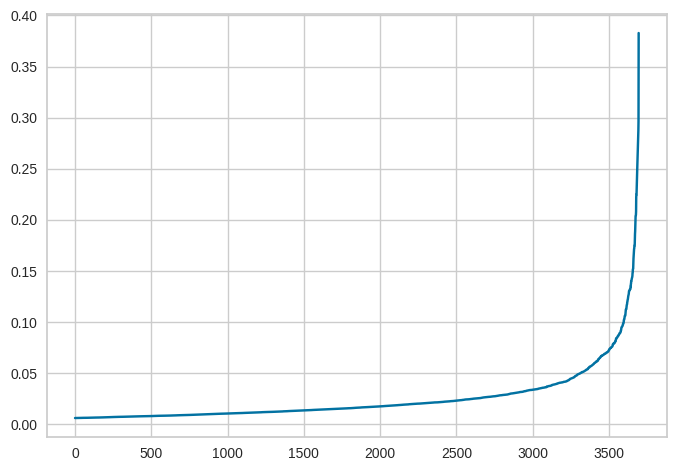

In [64]:
plt.plot( distances[2000:] )

In [65]:
dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5. Results

In [66]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}
     #'DBSCAN': dbscan_list}
).T

df_results.columns = clusters

In [67]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.387943,0.378025,0.379053,0.373435,0.421535,0.411376,0.431100,0.463904,0.490012,0.511801,0.523524,0.511415,0.507174,0.512876,0.518264,0.522543,0.521845,0.529778,0.532885,0.531142,0.522815,0.532752,0.522422
GMM,0.387507,0.343232,0.358383,0.339528,0.397781,0.409740,0.410988,0.455360,0.451398,0.415816,0.510645,0.490197,0.476894,0.518902,0.470124,0.474748,0.465751,0.468517,0.455840,0.498449,0.470044,0.483973,0.472797
HC,0.337941,0.346546,0.358514,0.357776,0.343623,0.373641,0.404196,0.437762,0.458972,0.495923,0.509569,0.491619,0.501762,0.499409,0.504520,0.505738,0.506215,0.510106,0.515771,0.523171,0.532092,0.515954,0.520737


# <font color='red'> 8.0. Model Training </font>

## 8.1. Final model

In [101]:
## model definition
k = 5
gmm_model = mx.GaussianMixture( n_components=k, n_init=300, random_state=32 )

# model training
gmm_model.fit( X )

# model predict
labels = gmm_model.predict( X )

## 8.2. Cluster Validation

In [102]:
## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.3376518785953522


# <font color='red'> 9.0. Cluster Analysis </font>

In [103]:
df9 = X.copy()
df9['cluster'] = labels

## 9.1. Visualization Inspection

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

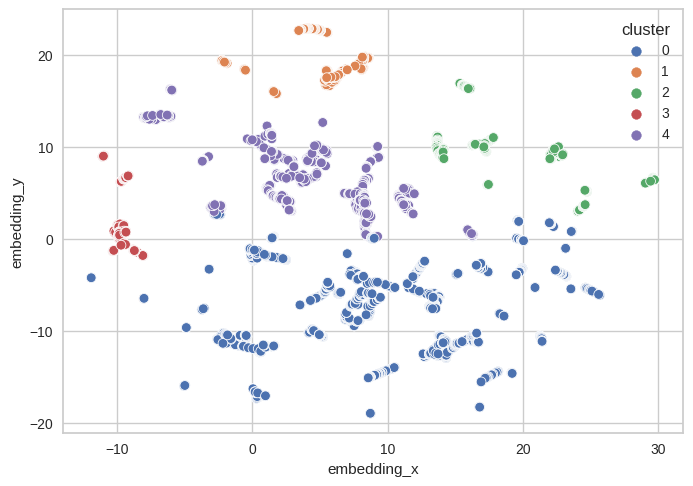

In [104]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

## 9.4. Cluster Profile

In [105]:
df92 = df4[ cols_selected ].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,4
1,13047,3232.59,56.0,171.0,0.028302,35.0,4
2,12583,6705.38,2.0,232.0,0.040323,50.0,4
3,13748,948.25,95.0,28.0,0.017921,0.0,4
4,15100,876.00,333.0,3.0,0.073171,22.0,0


In [106]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster.sort_values( 'gross_revenue', ascending=False )

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
4,4,1936,33.994732,3766.343936,79.184401,205.248967,0.332598,81.833678
1,1,476,8.358209,1064.553424,78.235294,45.865546,0.175046,7.949580
2,2,561,9.850746,925.198324,152.586453,63.520499,0.758067,4.864528
3,3,296,5.197542,859.367905,82.057432,32.290541,0.151783,4.939189
0,0,2426,42.598771,631.854864,150.647980,25.978566,0.791187,4.809563


### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 1182 (20% do customers )
    - Faturamento médio: $4367,00 dólares
    - Recência média: 96 dias
    - Média de Produtos comprados: 190 produtos
    - Frequência de Produtos comprados: 0.28 produtos/dia
        
### Cluster 02:
    - Número de customers: 31 (0.71 do customers )
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52 dólares
        
### Cluster 03:
    - Número de customers: 4.335 (99% do customers )
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57 dólares

# <font color='red'> 10.0. Análise Exploratória de Dados </font>

In [107]:
df10 = df92.copy()

In [108]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,4
1,13047,3232.59,56.0,171.0,0.028302,35.0,4
2,12583,6705.38,2.0,232.0,0.040323,50.0,4
3,13748,948.25,95.0,28.0,0.017921,0.0,4
4,15100,876.00,333.0,3.0,0.073171,22.0,0


## 10.1. MindMap de hipoteses

## Hipóteses Compra

1. **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras**
2. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras**
3. **Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes**
4. **A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral.**
5. **O percentil do gmv pelos clientes insiders.**

### H1: **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras**
**Verdade:** O cluster insider possuem um volume de compra de produtos de 42.59%

In [109]:
# soma da qtde de produtos do insiders
df_sales_insiders = df10.loc[df10['cluster'] == 4, 'qtde_products'].sum()
df_sales_total = df10.loc[:, 'qtde_products'].sum()

# soma da qtde de produtos total
print( '% Sales Insiders: {:.2f}%'.format( 100*df_sales_insiders / df_sales_total ) )

% Sales Insiders: 75.34%


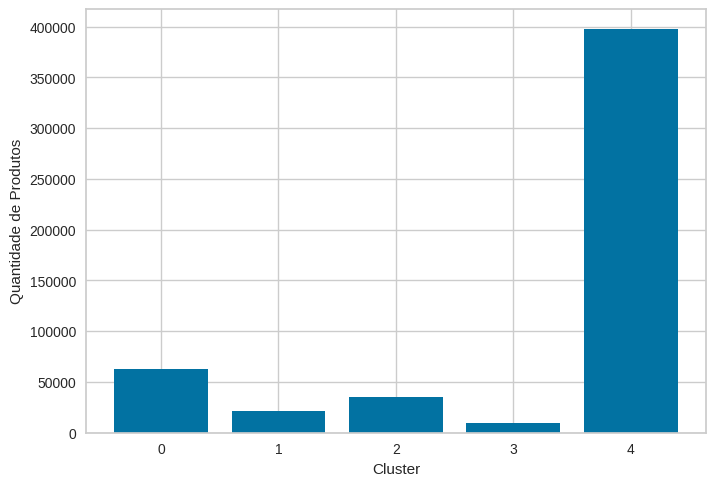

In [110]:
# Assuming 'df_products' is your DataFrame
df_products = df10[['cluster', 'qtde_products']].groupby('cluster').sum().reset_index()
df_products = df_products.sort_values(by='qtde_products', ascending=False)

plt.bar(df_products['cluster'], df_products['qtde_products'])
plt.xlabel('Cluster')
plt.ylabel('Quantidade de Produtos')
plt.show()

In [111]:
df_sales_insiders

397362.0

### H2. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras**
**Verdadeiro:** O cluster insider possuem um volume de GMV de 51.08%

In [114]:
# soma da qtde de produtos do insiders
df_gmv_insiders = df10.loc[df10['cluster'] == 4, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# soma da qtde de produtos total
print( '% GMV Insiders: {:.2f}%'.format( 100*df_gmv_insiders / df_gmv_total ) )

% GMV Insiders: 72.16%


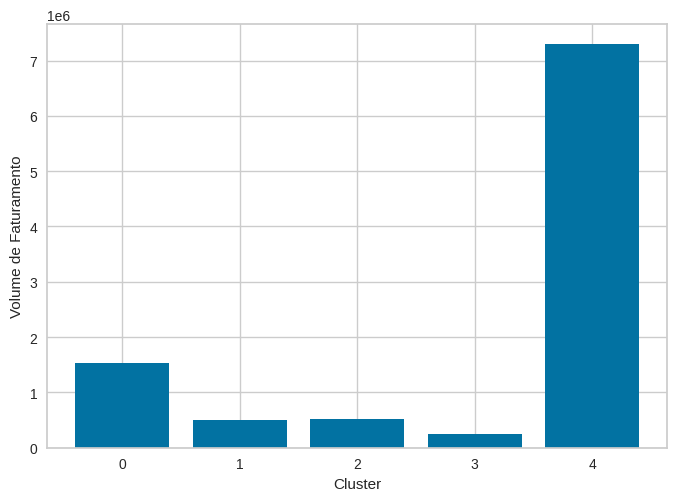

In [115]:
# Assuming 'df_products' is your DataFrame
df_products = df10[['cluster', 'gross_revenue']].groupby('cluster').sum().reset_index()
df_products = df_products.sort_values(by='gross_revenue', ascending=False)

plt.bar(df_products['cluster'], df_products['gross_revenue'])
plt.xlabel('Cluster')
plt.ylabel('Volume de Faturamento')
plt.show()

### H3. **Os clientes do cluster insiders tem um número de devolução médio abaixo da média da base total de clientes**
**Falso**: O cluser insiders tem a média de devoluções acima da média geral

In [116]:
# media de devolucao do cluster insider
df_avg_return_insiders = df10.loc[df10['cluster'] == 4, 'qtde_returns'].mean()

# media de devolucao do total
df_avg_return_all = df10['qtde_returns'].mean()

#
print( 'Avg Return Insiders: {} vs Avg Return All:{}'.format( np.round( df_avg_return_insiders, 0 ),
                                                              np.round( df_avg_return_all, 0 ) ) )

Avg Return Insiders: 82.0 vs Avg Return All:31.0


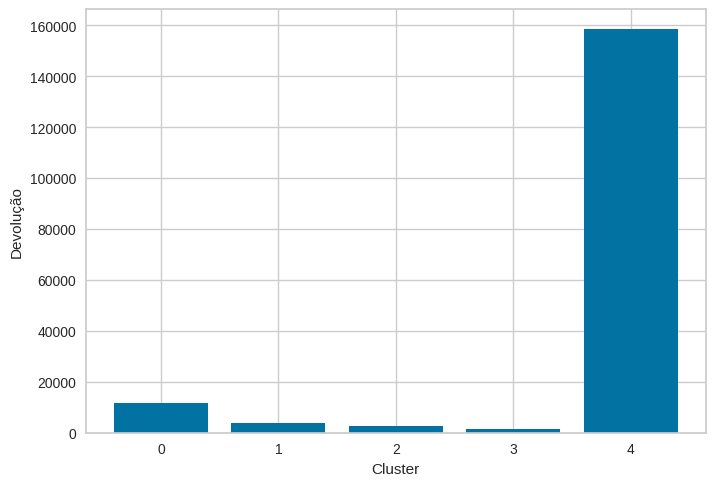

In [117]:
df_products = df10[['cluster', 'qtde_returns']].groupby('cluster').sum().reset_index()
df_products = df_products.sort_values(by='qtde_returns', ascending=False)

plt.bar(df_products['cluster'], df_products['qtde_returns'])
plt.xlabel('Cluster')
plt.ylabel('Devolução')
plt.show()

# <font color='red'> 11.0. Deploy To Production </font>